In [136]:
# import the necessary libraries

import math
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

In [137]:
# define helper functions

# maps risk CATEGORICAL to natural number system (1-5)
def castRisk(character):
    mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'F': 6}
    if character in mapping.keys():
        return mapping[character]
    
#-------------------------------------------------------------------
# returns how many distinct values are in var
def distinct(d, var, num):
    """
    input:
    d: a list of binary numbers representing whether we purchase credits from some project developers
    var: a list of (homogeneous) objects representing the optimized combination
    num: length of var
    """

    modVar = []
    for index in range(num):
        if d[index]:
            modVar.append(var[index])
    occurence = {}
    for item in modVar:
        if item not in occurence.keys():
            occurence[item] = 1
        else:
            occurence[item] = occurence[item] + 1
    return len(occurence.keys())

#-------------------------------------------------------------------
# returns variance of x
def Var(x, num):
    """
    input:
    x: a list of integers representing the optimized combination
    num: length of x
    """

    Xsum = 0
    for num in x:
        Xsum = Xsum + num
    mean = Xsum / num
    sq_sum = 0
    for num in x:
        sq_sum = sq_sum + (num - mean)**2
    return sq_sum / num

#-------------------------------------------------------------------
# returns the number of occurrences of proj in var
def occurrence(df, d, var, num, proj):
    """
    input:
    d: a list of binary numbers representing whether we purchase credits from some project developers
    var: a list of integers representing the optimized combination
    num: length of var
    proj: a string representing the risk grade of the project ('A', 'B', 'C', 'D', 'F')
    """
    
    count = 0
    for index in range(num):
        if d[index]:
            if df['Grade'][index] == proj:
                count = count + var[index]
    return count

#-------------------------------------------------------------------

In [138]:
# Import the data
fileName = '/Users/michael_khalfin/Downloads/Book7.xlsx'
df = pd.read_excel(fileName)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Project Title      79 non-null     object 
 1   Location           79 non-null     object 
 2   Project Developer  79 non-null     object 
 3   Type               79 non-null     object 
 4   Mechanism          79 non-null     object 
 5   Vintage            79 non-null     float64
 6   Quantity           79 non-null     float64
 7   Dollar             79 non-null     float64
 8   Registry           79 non-null     object 
 9   Standard           79 non-null     object 
 10  Grade              79 non-null     object 
dtypes: float64(3), object(8)
memory usage: 7.4+ KB


In [139]:
df.head(10)

,Project Title,Location,Project Developer,Type,Mechanism,Vintage,Quantity,Dollar,Registry,Standard,Grade
0,Promoting hydroelectric green energy in India,India,EVI Green Markets Pte. Ltd,Hydropower,Avoidance,2019.0,2617.0,2.6300,CDM,CDM,B
1,Promoting hydroelectric green energy in India,India,EVI Green Markets Pte. Ltd,Hydropower,Avoidance,2018.0,20000.0,2.6300,CDM,CDM,B
2,Promoting hydroelectric green energy in India,India,EVI Green Markets Pte. Ltd,Hydropower,Avoidance,2017.0,20000.0,2.6300,CDM,CDM,B
3,The Nut Collectors | Guardians of the Forest,Peru,Bosques Amazónicos,REDD+,Avoidance,2020.0,29500.0,11.2564,Verra,VCS,F
4,The Nut Collectors | Guardians of the Forest,Peru,Bosques Amazónicos,REDD+,Avoidance,2018.0,30000.0,10.0152,Verra,VCS,F
5,Promoting green energy innovation in Brazil,Brazil,Rima Industrial S/A,Other (Chemical Industrial),Avoidance,2020.0,40672.0,3.1244,CDM,CDM,B
6,Promoting green energy innovation in Brazil,Brazil,Rima Industrial S/A,Other (Chemical Industrial),Avoidance,2013.0,237240.0,3.1244,CDM,CDM,B
7,Promoting green energy innovation in Brazil,Brazil,Rima Industrial S/A,Other (Chemical Industrial),Avoidance,2012.0,126585.0,2.0116,CDM,CDM,B
8,Promoting green energy innovation in Brazil,Brazil,Rima Industrial S/A,Other (Chemical Industrial),Avoidance,2011.0,83248.0,2.0116,CDM,CDM,B
9,Promoting green energy innovation in Brazil,Brazil,Rima Industrial S/A,Other (Chemical Industrial),Avoidance,2010.0,43554.0,2.0116,CDM,CDM,B


In [140]:
import ipywidgets as widgets
from IPython.display import display

# Create text input widgets
budgetInput = widgets.Text(
    value='100000',  # Initial value of the text input
    placeholder='100000',  # Placeholder text
    description='Budget:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
deficitInput = widgets.Text(
    value='10000',  # Initial value of the text input
    placeholder='10000',  # Placeholder text
    description='Deficit:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
# Create a dropdown widget
options = ["Low", "Medium", "High"]
riskDropdown = widgets.Dropdown(
    options=options,     # List of options
    value=options[2],    # Initial selected option
    description='Select:',  # Label for the dropdown
    disabled=False       # Set to True to disable the dropdown
)

# Display the text input widget
display(budgetInput)
display(deficitInput)
display(riskDropdown)

Text(value='100000', description='Budget:', placeholder='100000')

Text(value='10000', description='Deficit:', placeholder='10000')

Dropdown(description='Select:', index=2, options=('Low', 'Medium', 'High'), value='High')

In [141]:
# Save the values
budget = budgetInput.value
budget = int(budget)
deficit = deficitInput.value
deficit = int(deficit)

# Low, Medium, High
if riskDropdown.value == "low":
    pct = .05
elif riskDropdown.value == "medium":
    pct = .07
else:
    pct = .1

In [142]:
# Verify values satisfy some basic requirements

# 1. check if budget is big enough
truncated = df.sort_values(by="Dollar", ascending=True)[["Dollar", "Quantity"]]
amt = 0
total_quantity = 0
for index, row in truncated.iterrows():
    price = row["Dollar"]
    quantity = row["Quantity"]
    for i in range(int(quantity)):
        if total_quantity >= deficit:
            break
        amt += price
        total_quantity += 1
    if total_quantity >= deficit:
        break

if not (budget >= amt):
    raise ValueError("Budget is out of bounds")

# 2. check if deficit is small enough
if not (deficit <= df["Quantity"].sum()):
    raise ValueError("Deficit is out of bounds")

# 3. check if all values are positive
if not (budget >= 0 and deficit >= 0):
    raise ValueError("Negative values are not allowed")

In [143]:
# Optimization #1: "Big" Optimization

# Initialize model
model = gp.Model("MIP_Model")

# Number of projects in the data table
numProjDev = df.shape[0]

# Add variables to the model
x = model.addVars(numProjDev, vtype=GRB.INTEGER, name="quantity")
d = model.addVars(numProjDev, vtype=GRB.BINARY, name="devTF")
dbar = model.addVar(vtype=GRB.INTEGER, name="amtDevs")
v = model.addVar(vtype=GRB.INTEGER, name="amtVintage")
r = model.addVar(vtype=GRB.INTEGER, name="amtRegistry")
l = model.addVar(vtype=GRB.INTEGER, name="amtLocations")
m = model.addVar(vtype=GRB.INTEGER, name="amtMechanisms")
t = model.addVar(vtype=GRB.INTEGER, name="amtTypes")

# Initialize the objective function
# location, type, and registry are the most important factors
obj = l + t + r - dbar - v - m
model.setObjective(obj, GRB.MAXIMIZE)

# Constraints
model.addConstr(gp.quicksum(df['Dollar'][i]*x[i] for i in range(numProjDev)) <= budget, "price")
for i in range(numProjDev):
    model.addConstr(x[i] <= df["Quantity"][i], "quantity")
    model.addConstr(d[i] * x[i] - x[i] >= -1*pct, "1st binary constraint")
    model.addConstr(d[i] * x[i] - d[i] >= -1*pct, "2nd binary constraint")
    model.addConstr(x[i] / deficit <= pct, "maximum concentration of each project")
model.addConstr(gp.quicksum(d[i] for i in range(numProjDev)) - dbar >= 0, "num of devs")
model.addConstr(distinct(d, df['Vintage'], numProjDev) - v >= 0, "vintage")
model.addConstr(distinct(d, df['Registry'], numProjDev) - r >= 0, "registry")
model.addConstr(distinct(d, df['Location'], numProjDev) - l >= 0, "location")
model.addConstr(distinct(d, df['Mechanism'], numProjDev) - m >= 0, "mechanism")
model.addConstr(distinct(d, df['Type'], numProjDev) - t >= 0, "typeProject")
model.addConstr(gp.quicksum(x[i] for i in range(numProjDev)) >= deficit, "deficit")

# Optimization
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 166 rows, 164 columns and 401 nonzeros
Model fingerprint: 0x67c94177
Model has 158 quadratic constraints
Variable types: 0 continuous, 164 integer (79 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 5e+05]
  QRHS range       [1e-01, 1e-01]
Presolve removed 8 rows and 7 columns
Presolve time: 0.00s
Presolved: 158 rows, 157 columns, 470 nonzeros
Variable types: 0 continuous, 157 integer (79 binary)
Found heuristic solution: objective 39.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 39 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.90

In [144]:
# Get the solution
valueDict = {dbar.varName:dbar.X, v.varName:v.X, r.varName:r.X, l.varName:l.X, m.varName:m.X, t.varName:t.X}
valueDict

{'amtDevs': -0.0,
 'amtVintage': -0.0,
 'amtRegistry': 10.0,
 'amtLocations': 17.0,
 'amtMechanisms': -0.0,
 'amtTypes': 12.0}

In [145]:
# Create text input widgets
headerText = widgets.HTML(
    value="<b>These are lower bounds:</b>",
    #description='Static Text:',
)
amtDevs = widgets.Text(
    value=str(int(valueDict["amtDevs"])),  # Initial value of the text input
    description='Developers:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
amtVintage = widgets.Text(
    value=str(int(valueDict["amtVintage"])),  # Initial value of the text input
    description='Vintage:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
amtRegistry = widgets.Text(
    value=str(int(valueDict["amtRegistry"])),  # Initial value of the text input
    description='Registry:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
amtLocations = widgets.Text(
    value=str(int(valueDict["amtLocations"])),  # Initial value of the text input
    description='Locations:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
amtMechanisms = widgets.Text(
    value=str(int(valueDict["amtMechanisms"])),  # Initial value of the text input
    description='Mechanisms:',  # Label for the input field
    disabled=False  # Set to True to disable input
)
amtTypes = widgets.Text(
    value=str(int(valueDict["amtTypes"])),  # Initial value of the text input
    description='Types:',  # Label for the input field
    disabled=False  # Set to True to disable input
)

display(headerText)
display(amtDevs)
display(amtVintage)
display(amtRegistry)
display(amtLocations)
display(amtMechanisms)
display(amtTypes)

HTML(value='<b>These are lower bounds:</b>')

Text(value='0', description='Developers:')

Text(value='0', description='Vintage:')

Text(value='10', description='Registry:')

Text(value='17', description='Locations:')

Text(value='0', description='Mechanisms:')

Text(value='12', description='Types:')

In [146]:
# Save the values
amtDevs = amtDevs.value
amtDevs = int(amtDevs)

amtVintage = amtVintage.value
amtVintage = int(amtVintage)

amtRegistry = amtRegistry.value
amtRegistry = int(amtRegistry)

amtLocations = amtLocations.value
amtLocations = int(amtLocations)

amtMechanisms = amtMechanisms.value
amtMechanisms = int(amtMechanisms)

amtTypes = amtTypes.value
amtTypes = int(amtTypes)

In [147]:
# Verify values satisfy some basic requirements
if not (amtTypes >= 0 and amtTypes <= df["Type"].nunique()):
    raise ValueError("amtTypes is out of bounds")
if not (amtVintage >= 0 and amtVintage <= df["Vintage"].nunique()):
    raise ValueError("amtVintage is out of bounds")
if not (amtRegistry >= 0 and amtRegistry <= df["Registry"].nunique()):
    raise ValueError("amtRegistry is out of bounds")
if not (amtLocations >= 0 and amtLocations <= df["Location"].nunique()):
    raise ValueError("amtLocations is out of bounds")
if not (amtMechanisms >= 0 and amtMechanisms <= df["Mechanism"].nunique()):
    raise ValueError("amtMechanisms is out of bounds")
if not (amtDevs >= 0 and amtDevs <= df.shape[0]):
    raise ValueError("amtDevs is out of bounds")

In [148]:
penalty = 100

In [158]:
# Optimization #2: "Constrained" Optimization

# Initialize model
model = gp.Model("MIP_Model")

# Number of projects in the data table
numProjDev = df.shape[0]

# Add variables to the model
x = model.addVars(numProjDev, vtype=GRB.INTEGER, name="quantity")
d = model.addVars(numProjDev, vtype=GRB.BINARY, name="devTF")

# Initialize the objective function
obj = sum(elem1 * castRisk(elem2) for elem1, elem2 in zip(x, df['Grade'])) + penalty * Var(x, numProjDev)
model.setObjective(obj, GRB.MINIMIZE)

# Constraints
model.addConstr(gp.quicksum(df['Dollar'][i]*x[i] for i in range(numProjDev)) <= budget, "price")
for i in range(numProjDev):
    model.addConstr(x[i] <= df["Quantity"][i], "quantity")
    model.addConstr(d[i] * x[i] - x[i] >= -1*pct, "1st binary constraint")
    model.addConstr(d[i] * x[i] - d[i] >= -1*pct, "2nd binary constraint")
    model.addConstr(x[i] / deficit <= pct, "maximum concentration of each project")
model.addConstr(gp.quicksum(d[i] for i in range(numProjDev)) >= amtDevs, "amtDevs")
model.addConstr(distinct(d, df['Vintage'], numProjDev) >= amtVintage, "amtVintage")
model.addConstr(distinct(d, df['Registry'], numProjDev) >= amtRegistry, "amtRegistry")
model.addConstr(distinct(d, df['Location'], numProjDev) >= amtLocations, "amtLocation")
model.addConstr(distinct(d, df['Mechanism'], numProjDev) >= amtMechanisms, "amtMechanism")
model.addConstr(distinct(d, df['Type'], numProjDev) >= amtTypes, "amtTypes")
model.addConstr(gp.quicksum(x[i] for i in range(numProjDev)) >= deficit, "deficit")

# Optimization
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 166 rows, 158 columns and 395 nonzeros
Model fingerprint: 0x3b9faa12
Model has 158 quadratic constraints
Variable types: 0 continuous, 158 integer (79 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 5e+05]
  QRHS range       [1e-01, 1e-01]
Presolve removed 8 rows and 1 columns
Presolve time: 0.01s
Presolved: 158 rows, 157 columns, 470 nonzeros
Variable types: 0 continuous, 157 integer (79 binary)
Found heuristic solution: objective 64532.987179

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 64533 

Optimal solution found (tolerance 1.00e-04)
Best objective

In [150]:
# Return the portfolio as a list of quantities (int) for each project 
portfolio = [x[i].X for i in range(numProjDev)]

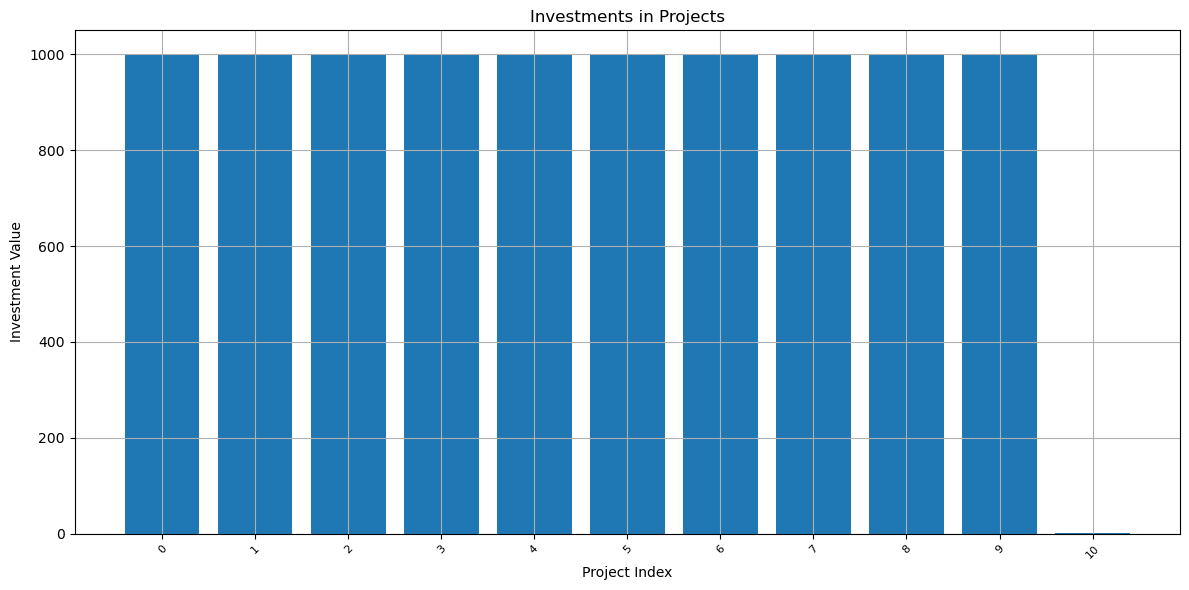

In [151]:
# Visualize the portfolio
import matplotlib.pyplot as plt
import numpy as np

# Filter out zero investments and their corresponding project indices
filtered_portfolio = [value for value in portfolio if value != 0]
num_investments = len(filtered_portfolio)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot
x = np.arange(num_investments)
plt.bar(x, filtered_portfolio)

# Set the x-axis ticks to show the project indices
plt.xticks(x, [str(i) for i in range(num_investments)], rotation=45, fontsize=8)

# Set plot title and labels
plt.title('Investments in Projects')
plt.xlabel('Project Index')
plt.ylabel('Investment Value')

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

In [152]:
shadowPriceDict = {}
for constr in model.getConstrs():
    if constr.ConstrName in ["amtDevs", "amtVintage", "amtRegistry", "amtLocation", "amtMechanism", "amtTypes"]:
        shadowPriceDict[constr.ConstrName] = constr.RHS

shadowPriceDict

{'amtDevs': 0.0,
 'amtVintage': 0.0,
 'amtRegistry': 0.0,
 'amtLocation': 0.0,
 'amtMechanism': 0.0,
 'amtTypes': 0.0}

In [175]:
# Initialize the upper bounds for parameters
upper_bounds = {
    'amtDevs': df.shape[0],
    'amtVintage': df['Vintage'].nunique(),
    'amtRegistry': df['Registry'].nunique(),
    'amtLocations': df['Location'].nunique(),
    'amtMechanisms': df['Mechanism'].nunique(),
    'amtTypes': df['Type'].nunique()
}

# Initialize lists to store results
parameter_names = list(upper_bounds.keys())
parameter_values = {param: [] for param in parameter_names}
shadow_prices = {param: [] for param in parameter_names}

# Create a function to solve the linear program and retrieve shadow prices
def solve_lp_and_get_shadow_prices(df, budget, penalty, pct, deficit, amtDevs, amtVintage, amtRegistry, amtLocations, amtMechanisms, amtTypes):
    # Initialize model
    model = gp.Model("MIP_Model")

    # Number of projects in the data table
    numProjDev = df.shape[0]

    # Add variables to the model
    x = model.addVars(numProjDev, vtype=GRB.INTEGER, name="quantity")
    d = model.addVars(numProjDev, vtype=GRB.BINARY, name="devTF")

    # Initialize the objective function
    obj = sum(elem1 * castRisk(elem2) for elem1, elem2 in zip(x, df['Grade'])) + + penalty * gp.quicksum(x[i] for i in range(numProjDev))
    model.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    model.addConstr(gp.quicksum(df['Dollar'][i]*x[i] for i in range(numProjDev)) <= budget, "price")
    for i in range(numProjDev):
        model.addConstr(x[i] <= df["Quantity"][i], "quantity")
        model.addConstr(d[i] * x[i] - x[i] >= -1*pct, "1st binary constraint")
        model.addConstr(d[i] * x[i] - d[i] >= -1*pct, "2nd binary constraint")
        model.addConstr(x[i] / deficit <= pct, "maximum concentration of each project")
    model.addConstr(gp.quicksum(d[i] for i in range(numProjDev)) >= amtDevs, "amtDevs")
    model.addConstr(distinct(d, df['Vintage'], numProjDev) >= amtVintage, "amtVintage")
    model.addConstr(distinct(d, df['Registry'], numProjDev) >= amtRegistry, "amtRegistry")
    model.addConstr(distinct(d, df['Location'], numProjDev) >= amtLocations, "amtLocation")
    model.addConstr(distinct(d, df['Mechanism'], numProjDev) >= amtMechanisms, "amtMechanism")
    model.addConstr(distinct(d, df['Type'], numProjDev) >= amtTypes, "amtTypes")
    model.addConstr(gp.quicksum(x[i] for i in range(numProjDev)) >= deficit, "deficit")

    # Optimization
    model.optimize()

    # Get shadow prices
    shadow_prices = {
        "amtDevs": model.getConstrByName("amtDevs").getAttr("RHS"),
        "amtVintage": model.getConstrByName("amtVintage").getAttr("RHS"),
        "amtRegistry": model.getConstrByName("amtRegistry").getAttr("RHS"),
        "amtLocation": model.getConstrByName("amtLocation").getAttr("RHS"),
        "amtMechanism": model.getConstrByName("amtMechanism").getAttr("RHS"),
        "amtTypes": model.getConstrByName("amtTypes").getAttr("RHS")
    }

    return shadow_prices

# Loop through each parameter
for param_name in parameter_names:
    max_value = upper_bounds[param_name]
    step = 1

    # Vary the current parameter value from 0 to the upper bound
    parameter_values[param_name] = np.arange(0, max_value + step, step)

    # Initialize a list to store shadow prices for this parameter
    shadow_prices_parameter = []

    # Loop through the parameter values
    for param_value in parameter_values[param_name]:
        # Solve the linear program and retrieve the shadow prices
        shadow_prices_parameter.append(solve_lp_and_get_shadow_prices(
            df,
            100000000000,
            penalty,
            pct,
            100,
            upper_bounds['amtDevs'],
            upper_bounds['amtVintage'],
            upper_bounds['amtRegistry'],
            upper_bounds['amtLocations'],
            upper_bounds['amtMechanisms'],
            upper_bounds['amtTypes']
        ))

    # Store the shadow prices for this parameter
    shadow_prices[param_name] = shadow_prices_parameter

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 166 rows, 158 columns and 395 nonzeros
Model fingerprint: 0x49c448ac
Model has 158 quadratic constraints
Variable types: 0 continuous, 158 integer (79 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+11]
  QRHS range       [1e-01, 1e-01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166 rows and 158 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 21841 

Optimal solution found (tolerance 1.00e-04)
Best objectiv

In [172]:
parameter_names

['amtDevs',
 'amtVintage',
 'amtRegistry',
 'amtLocations',
 'amtMechanisms',
 'amtTypes']

In [173]:
parameter_values

{'amtDevs': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 'amtVintage': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'amtRegistry': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'amtLocations': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 'amtMechanisms': array([0, 1, 2]),
 'amtTypes': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

In [176]:
shadow_prices

{'amtDevs': [{'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry': 0.0,
   'amtLocation': 0.0,
   'amtMechanism': 0.0,
   'amtTypes': 0.0},
  {'amtDevs': 79.0,
   'amtVintage': 0.0,
   'amtRegistry'